**Initial step:** Please try to put the extracted CamVid folder in your Google Drive!
So now you could mount your data to this ipynb!

In [0]:

from google.colab import drive
drive.mount('/content/drive')

In [0]:
# if you mount Google drive correctly, the following commands should be able to executed correctly
!ls /content/drive/
%cd "/content/drive/My Drive/Colab Notebooks/HW4_updated1/"
%cd "CamVid"

!ls

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
import random

from matplotlib import pyplot as plt
import numpy as np
import time
import sys
import os
from os import path

from PIL import Image
import pandas as pd
from torchvision.models.vgg import VGG




In [0]:
seed = 1450
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:

root_dir   = "/content/drive/My Drive/Colab Notebooks/HW4_updated1/CamVid/"
train_file = os.path.join(root_dir, "train.csv")
val_file   = os.path.join(root_dir, "val.csv")

print("training csv exits:{}".format(path.exists(train_file)))
print("validation csv exits:{}".format(path.exists(val_file)))

# the folder to save results for comparison
folder_to_save_validation_result = '/content/drive/My Drive/Colab Notebooks/HW4_updated1/CamVid/result_comparision/' 

if os.path.isdir(folder_to_save_validation_result) == False:
    os.mkdir(folder_to_save_validation_result)


# the number of segmentation classes
num_class = 12 # 32 for original CamVid
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR

h, w = 256, 256
train_h = 256
train_w = 256
val_h = 256
val_w = 256

## parameters for Solver-Adam in this example
batch_size = 6 #
epochs     = 20 # don't try to improve the performance by simply increasing the training epochs or iterations
lr         = 1e-4    # achieved besty results 
step_size  = 100 # Won't work when epochs <=100
gamma      = 0.5 # 
#

## index for validation images
global_index = 0

# pixel accuracy and mIOU list 
pixel_acc_list = []
mIOU_list = []

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

class CamVidDataset(Dataset):

    def __init__(self, csv_file, phase, n_class=num_class, crop=True, flip_rate=0.5):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate       

        self.resize_h = h
        self.resize_w = w        
        
        if phase == 'train':
            self.new_h = train_h
            self.new_w = train_w
            self.crop = crop
        elif phase == 'val':
            self.flip_rate = 0.
            self.crop = False # False
            self.new_h = val_h
            self.new_w = val_w


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]                
        img_name = root_dir  + img_name                        
        img = Image.open(img_name).convert('RGB')  

        label_name = self.data.iloc[idx, 1]        
        label_name = root_dir  + label_name                       
        label_image = Image.open(label_name)
        label = np.asarray(label_image)

        # In training mode, the crop strategy is random-shift crop.
        # In validation model, it is center crop.
        if self.crop:            
            w, h = img.size
            A_x_offset = np.int32(np.random.randint(0, w - self.new_w + 1, 1))[0]
            A_y_offset = np.int32(np.random.randint(0, h - self.new_h + 1, 1))[0]

            img = img.crop((A_x_offset, A_y_offset, A_x_offset + self.new_w, A_y_offset + self.new_h)) # left, top, right, bottom
            label_image = label_image.crop((A_x_offset, A_y_offset, A_x_offset + self.new_w, A_y_offset + self.new_h)) # left, top, right, bottom
        else:            
            w, h = img.size
            A_x_offset = int((w - self.new_w)/2)
            A_y_offset = int((h - self.new_h)/2)
            
            img = img.crop((A_x_offset, A_y_offset, A_x_offset + self.new_w, A_y_offset + self.new_h)) # left, top, right, bottom
            label_image = label_image.crop((A_x_offset, A_y_offset, A_x_offset + self.new_w, A_y_offset + self.new_h)) # left, top, right, bottom

            label_image_h, label_image_w = label_image.size

        # we could try to revise the values in label for reducing the number of segmentation classes
        label = np.array(label_image)              

        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)
        
        # reduce mean in terms of BGR
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        for c in range(self.n_class):
            target[c][label == c] = 1

        sample = {'X': img, 'Y': target, 'l': label}

        return sample


train_data = CamVidDataset(csv_file=train_file, phase='train')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)

val_data = CamVidDataset(csv_file=val_file, phase='val', flip_rate=0)
val_loader = DataLoader(val_data, batch_size=1, num_workers=8)



training csv exits:True
validation csv exits:True


In [0]:
# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:            
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output

In [0]:
class FCN8s(nn.Module):
    #Ref: https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1
    #The layer description is accordance with the above fiture instead of the original paper. Alex 2019/12/03 
    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)                      
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)           
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

In [8]:
# load pretrained weights and define FCN8s
vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN8s(pretrained_net=vgg_model, n_class=num_class)

ts = time.time()
vgg_model = vgg_model.cuda()
fcn_model = fcn_model.cuda()
fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) 

print(fcn_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 238MB/s]


Finish cuda loading, time elapsed 4.86567759513855
DataParallel(
  (module): FCN8s(
    (pretrained_net): VGGNet(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
    

In [0]:
def val(epoch):
    fcn_model.eval()
    total_ious = []
    pixel_accs = []
                    
    
    for iter, batch in enumerate(val_loader): ## batch is 1 in this case
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])        

        output = fcn_model(inputs)                                
        
        # only save the 1st image for comparison
        if iter == 0:
            print('---------iter={}'.format(iter))
            # generate images
            images = output.data.max(1)[1].cpu().numpy()[:,:,:]
            image = images[0,:,:]        
            save_result_comparison(batch['X'], image)
                            
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape                
        pred = output.transpose(0, 2, 3, 1).reshape(-1, num_class).argmax(axis=1).reshape(N, h, w)        
        target = batch['l'].cpu().numpy().reshape(N, h, w)

        for p, t in zip(pred, target):
            total_ious.append(iou(p, t))
            pixel_accs.append(pixel_acc(p, t))

    # Calculate average IoU
    total_ious = np.array(total_ious).T  # n_class * val_len
    ious = np.nanmean(total_ious, axis=1)
    pixel_accs = np.array(pixel_accs).mean()
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}".format(epoch, pixel_accs, np.nanmean(ious), ious))
    
    global pixel_acc_list
    global mIOU_list
    
    pixel_acc_list.append(pixel_accs)
    mIOU_list.append(np.nanmean(ious))

In [0]:
def train():
    for epoch in range(epochs):
        scheduler.step()

        ts = time.time()
        for iter, batch in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.data.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        

        val(epoch)
        
    highest_pixel_acc = max(pixel_acc_list)
    highest_mIOU = max(mIOU_list)        
    
    highest_pixel_acc_epoch = pixel_acc_list.index(highest_pixel_acc)
    highest_mIOU_epoch = mIOU_list.index(highest_mIOU)
    
    print("The highest mIOU is {} and is achieved at epoch-{}".format(highest_mIOU, highest_mIOU_epoch))
    print("The highest pixel accuracy  is {} and is achieved at epoch-{}".format(highest_pixel_acc, highest_pixel_acc_epoch))  

In [0]:
def save_result_comparison(input_np, output_np):
    means     = np.array([103.939, 116.779, 123.68]) / 255.
    
    global global_index
    
    original_im_RGB = np.zeros((256,256,3))    
    original_im_RGB[:,:,0] = input_np[0,0,:,:]    
    original_im_RGB[:,:,1] = input_np[0,1,:,:]
    original_im_RGB[:,:,2] = input_np[0,2,:,:]
        
    original_im_RGB[:,:,0] = original_im_RGB[:,:,0] + means[0]
    original_im_RGB[:,:,1] = original_im_RGB[:,:,1] + means[1]
    original_im_RGB[:,:,2] = original_im_RGB[:,:,2] + means[2]
        
    original_im_RGB[:,:,0] = original_im_RGB[:,:,0]*255.0
    original_im_RGB[:,:,1] = original_im_RGB[:,:,1]*255.0
    original_im_RGB[:,:,2] = original_im_RGB[:,:,2]*255.0
    
    im_seg_RGB = np.zeros((256,256,3))

    # the following version is designed for 11-class version and could still work if the number of classes is fewer.
    for i in range(256):
        for j in range(256):
            if output_np[i,j] == 0:
                im_seg_RGB[i,j,:] = [128, 128, 128]
            elif output_np[i,j] == 1:  
                im_seg_RGB[i,j,:] = [128, 0, 0]
            elif output_np[i,j] == 2:  
                im_seg_RGB[i,j,:] = [192, 192, 128]    
            elif output_np[i,j] == 3:  
                im_seg_RGB[i,j,:] = [128, 64, 128]    
            elif output_np[i,j] == 4:  
                im_seg_RGB[i,j,:] = [0, 0, 192]    
            elif output_np[i,j] == 5:  
                im_seg_RGB[i,j,:] = [128, 128, 0]    
            elif output_np[i,j] == 6:  
                im_seg_RGB[i,j,:] = [192, 128, 128]    
            elif output_np[i,j] == 7:  
                im_seg_RGB[i,j,:] = [64, 64, 128]    
            elif output_np[i,j] == 8:  
                im_seg_RGB[i,j,:] = [64, 0, 128]    
            elif output_np[i,j] == 9:  
                im_seg_RGB[i,j,:] = [64, 64, 0]    
            elif output_np[i,j] == 10:  
                im_seg_RGB[i,j,:] = [0, 128, 192]    
                    
    # horizontally stack original image and its corresponding segmentation results     
    hstack_image = np.hstack((original_im_RGB, im_seg_RGB))             
    new_im = Image.fromarray(np.uint8(hstack_image))
    
    file_name = folder_to_save_validation_result + str(global_index) + '.jpg'
        
    global_index = global_index + 1
        
    new_im.save(file_name)     

In [0]:
# borrow functions and modify it from https://github.com/Kaixhin/FCN-semantic-segmentation/blob/master/main.py
# Calculates class intersections over unions
def iou(pred, target):
    ious = []
    for cls in range(num_class):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            ious.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
        # print("cls", cls, pred_inds.sum(), target_inds.sum(), intersection, float(intersection) / max(union, 1))
    return ious


def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [13]:
## perform training and validation
val(0)  # show the accuracy before training
train()

---------iter=0
epoch0, pix_acc: 0.03188079833984375, meanIoU: 0.0026567331949869794, IoUs: [0.        0.        0.        0.        0.        0.        0.
 0.0318808 0.        0.        0.        0.       ]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch0, iter0, loss: 0.6941513419151306
epoch0, iter10, loss: 0.5748529434204102
epoch0, iter20, loss: 0.42970696091651917
epoch0, iter30, loss: 0.34328407049179077
epoch0, iter40, loss: 0.30937284231185913
epoch0, iter50, loss: 0.284658819437027
epoch0, iter60, loss: 0.2899169921875
Finish epoch 0, time elapsed 45.65973234176636
---------iter=0
epoch0, pix_acc: 0.280057373046875, meanIoU: 0.03699695903525207, IoUs: [0.01511733 0.11441657 0.         0.28664062 0.00112133 0.
 0.         0.01362534 0.01304232 0.         0.         0.        ]
epoch1, iter0, loss: 0.25996071100234985
epoch1, iter10, loss: 0.24954891204833984
epoch1, iter20, loss: 0.2309388369321823
epoch1, iter30, loss: 0.22469152510166168
epoch1, iter40, loss: 0.21673355996608734
epoch1, iter50, loss: 0.22815294563770294
epoch1, iter60, loss: 0.2300620675086975
Finish epoch 1, time elapsed 11.496820211410522
---------iter=0
epoch1, pix_acc: 0.45017822265625, meanIoU: 0.07473893196596494, IoUs: [2.78991853e-02 2.79828819e

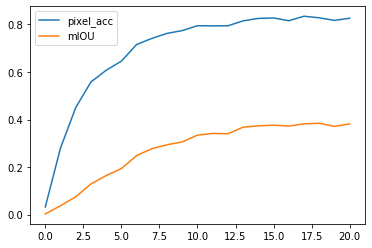

In [14]:
epoch = list(range(len(pixel_acc_list)))
plt.plot(epoch, pixel_acc_list, epoch, mIOU_list)
plt.legend(['pixel_acc', 'mIOU'])